In [23]:
import json
from tqdm import tqdm
import uuid
import os
from transformers import AutoProcessor, Kosmos2ForConditionalGeneration
import math
import imgviz
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy
from collections import defaultdict

In [24]:
def load_json(file_path):
    with open(file_path, "r") as f:
        data = json.load(f)
    return data

def bbox_absolute_to_relative(absolute_bbox, image_width_height):
    width, height = image_width_height
    x1 = absolute_bbox[0] / width
    y1 = absolute_bbox[1] / height
    x2 = absolute_bbox[2] / width
    y2 = absolute_bbox[3] / height
    relative_bbox = [x1, y1, x2, y2]
    return relative_bbox

def bbox_relative_to_absolute(relative_bbox, image_width_height):
    width, height = image_width_height
    x1 = relative_bbox[0] * width
    y1 = relative_bbox[1] * height
    x2 = relative_bbox[2] * width
    y2 = relative_bbox[3] * height
    absolute_bbox = [x1, y1, x2, y2]
    return absolute_bbox

def visualize_bbox(image, bbox_list, bbox_name_list,bbox_is_relative=True,with_id=False):
    assert len(bbox_list) == len(bbox_name_list), "bbox_list and bbox_name_list must have the same length"
    if isinstance(image, str):
        image = Image.open(image).convert("RGB")

    if bbox_is_relative:
        # 画像のサイズを取得
        image_width_height = (image.width, image.height)
        # 相対座標を絶対座標に変換
        bbox_list = [bbox_relative_to_absolute(bbox, image_width_height) for bbox in bbox_list]
        
    #bbox_name_listをソート、bbox_listも同じ順番にソート
    # bbox_name_list, bbox_list = zip(*sorted(zip(bbox_name_list, bbox_list), key=lambda x: x[0]))
    # bbox_name_list = list(bbox_name_list)
    # bbox_list = list(bbox_list)
    name_to_label_id_dict = {}
    label_id = 0
    for bbox_name in bbox_name_list:
        if bbox_name not in name_to_label_id_dict:
            name_to_label_id_dict[bbox_name] = label_id
            label_id += 1    
    
    # bbox_listの座標をy1, x1, y2, x2の形式に変換
    bboxes = []
    labels = []
    # label_id = -1
    # old_label = None
    count_object_dict = {}
    id_bbox_name_list = []
    for bbox ,bbox_name in zip(bbox_list, bbox_name_list):
        x1, y1, x2, y2 = bbox
        bboxes.append([y1, x1, y2, x2])
        # if old_label != bbox_name:
        #     label_id += 1
        #     old_label = bbox_name
        label_id = name_to_label_id_dict[bbox_name]
        if bbox_name not in count_object_dict:
            count_object_dict[bbox_name] = 0
        else:
            count_object_dict[bbox_name] += 1
        if with_id:
            bbox_name = f"{bbox_name}_{count_object_dict[bbox_name]}"
            id_bbox_name_list.append(bbox_name)
        labels.append(label_id)
    # bboxes = np.array([bbox[1],bbox[0],bbox[3],bbox[2]]).astype(np.int32).reshape(-1, 4)
    
    base_resolution = 100 * 100
    base_font_size = 3
    image_resolution = image.width * image.height
    font_size = int( base_font_size * (image_resolution / base_resolution) ** 0.5)
    
    if with_id:
        bbox_name_list = id_bbox_name_list
    image = imgviz.instances2rgb(np.array(image), bboxes=bboxes, labels=labels,font_size=font_size,captions=bbox_name_list)

    plt.imshow(image)
    plt.show()

In [25]:
def make_object_name_with_loc_dict_per_image(object_name_list: list[str], boxes: list[list[float]], original_w_h:tuple[int,int],sort_mode="L2") -> list[str]:
    object_name_bboxes_dict = {}
    for obj_name, box in zip(object_name_list, boxes):
        if obj_name not in object_name_bboxes_dict:
            object_name_bboxes_dict[obj_name] = []
        object_name_bboxes_dict[obj_name].append(box)
    
    reffer_prefix = "<phrase>"
    reffer_suffix = "</phrase>"
    box_prefix = "<object>"
    box_suffix = "</object>"
    loc_prefix = "<patch_index_"
    loc_suffix = ">"
    loc_delimiter = "</delimiter_of_multi_objects/>"
    image_resized_h_w_size = (224, 224)
    loc_w_h_pixels = (7, 7)
    loc_w_h_num = (int(image_resized_h_w_size[0] / loc_w_h_pixels[0]), int(image_resized_h_w_size[1] / loc_w_h_pixels[1]))

    loc_token_num = loc_w_h_num[0] * loc_w_h_num[1]
    loc_digits = len(str(loc_token_num))
    loc_tokens = ["{}{}{}".format(loc_prefix, str(i).zfill(loc_digits), loc_suffix) for i in range(loc_token_num)]
    loc_tokens_list = [[] for _ in range(loc_w_h_num[1])]  # loc_tokens_list[h][w]で指定する
    for index, h in enumerate(range(loc_w_h_num[1])):
        for w in range(loc_w_h_num[0]):
            item = loc_tokens[index * loc_w_h_num[0] + w]
            loc_tokens_list[h].append(item)

    object_name_with_loc_dict = {}
    for obj_name, box_list in object_name_bboxes_dict.items():
        object_name_with_loc_dict[obj_name] = []
        loc_bbox_list = []
        for box in box_list:

            # floorを使うのは0台なら0,31台なら31にするため
            loc_left_top = [
                int(math.floor(box[0] / original_w_h[0] * (loc_w_h_num[0]))),
                int(math.floor(box[1] / original_w_h[1] * (loc_w_h_num[1]))),
            ]  # (X,Y)
            loc_right_bottom = [
                int(math.floor(box[2] / original_w_h[0] * (loc_w_h_num[0]))),
                int(math.floor(box[3] / original_w_h[1] * (loc_w_h_num[1]))),
            ]  # (X,Y)
            if loc_left_top[0] > loc_w_h_num[0] - 1:
                loc_left_top[0] = loc_w_h_num[0] - 1
            if loc_left_top[1] > loc_w_h_num[1] - 1:
                loc_left_top[1] = loc_w_h_num[1] - 1
            if loc_right_bottom[0] > loc_w_h_num[0] - 1:
                loc_right_bottom[0] = loc_w_h_num[0] - 1
            if loc_right_bottom[1] > loc_w_h_num[1] - 1:
                loc_right_bottom[1] = loc_w_h_num[1] - 1
                
            loc_bbox_list.append([loc_left_top[0], loc_left_top[1], loc_right_bottom[0], loc_right_bottom[1]])
        if sort_mode == "L2":
            loc_bbox_list = sorted(loc_bbox_list, key=lambda x: x[0]**2 + x[1]**2)  # Sort by distance from the top-left corner (0,0)
        elif sort_mode == "UDLR":
            loc_bbox_list = sorted(loc_bbox_list, key=lambda x: (x[1],x[0], x[2]**2 + x[3]**2))  # Sort by left, then up, then distance from the top-left corner (0,0)
        else :
            raise ValueError("sor_mode must be 'L2' or 'UDLR'")
        
        for loc_box in loc_bbox_list:
            object_name_with_loc_dict[obj_name].append(
                f"{loc_tokens_list[loc_box[1]][loc_box[0]]}{loc_tokens_list[loc_box[3]][loc_box[2]]}"
            )
    return object_name_with_loc_dict

In [26]:
# def make_object_name_with_loc_dict_per_image(object_name_list: list[str], boxes: list[list[float]], original_w_h:tuple[int,int],sort_mode="L2") -> list[str]:
#     object_name_bboxes_dict = {}
#     for obj_name, box in zip(object_name_list, boxes):
#         if obj_name not in object_name_bboxes_dict:
#             object_name_bboxes_dict[obj_name] = []
#         object_name_bboxes_dict[obj_name].append(box)
    
#     tmp_object_name_bboxes_dict = {}
#     if sort_mode == "L2":
#         for obj_name, box_list in object_name_bboxes_dict.items():
#             tmp_object_name_bboxes_dict[obj_name] = sorted(box_list, key=lambda x: x[0]**2 + x[1]**2)  # Sort by distance from the top-left corner (0,0)
#     elif sort_mode == "UDLR":
#         for obj_name, box_list in object_name_bboxes_dict.items():
#             tmp_object_name_bboxes_dict[obj_name] = sorted(box_list, key=lambda x: (x[1],x[0], x[2]**2 + x[3]**2))  # Sort by left, then up, then distance from the top-left corner (0,0)
#     else :
#         raise ValueError("sor_mode must be 'L2' or 'UDLR'")
    
#     object_name_bboxes_dict = tmp_object_name_bboxes_dict
    
#     reffer_prefix = "<phrase>"
#     reffer_suffix = "</phrase>"
#     box_prefix = "<object>"
#     box_suffix = "</object>"
#     loc_prefix = "<patch_index_"
#     loc_suffix = ">"
#     loc_delimiter = "</delimiter_of_multi_objects/>"
#     image_resized_h_w_size = (224, 224)
#     loc_w_h_pixels = (7, 7)
#     loc_w_h_num = (int(image_resized_h_w_size[0] / loc_w_h_pixels[0]), int(image_resized_h_w_size[1] / loc_w_h_pixels[1]))

#     loc_token_num = loc_w_h_num[0] * loc_w_h_num[1]
#     loc_digits = len(str(loc_token_num))
#     loc_tokens = ["{}{}{}".format(loc_prefix, str(i).zfill(loc_digits), loc_suffix) for i in range(loc_token_num)]
#     loc_tokens_list = [[] for _ in range(loc_w_h_num[1])]  # loc_tokens_list[h][w]で指定する
#     for index, h in enumerate(range(loc_w_h_num[1])):
#         for w in range(loc_w_h_num[0]):
#             item = loc_tokens[index * loc_w_h_num[0] + w]
#             loc_tokens_list[h].append(item)

#     object_name_with_loc_dict = {}
#     for obj_name, box_list in object_name_bboxes_dict.items():
#         object_name_with_loc_dict[obj_name] = []
#         object_name_with_loc_list = []
#         for box in box_list:

#             # floorを使うのは0台なら0,31台なら31にするため
#             loc_left_top = [
#                 int(math.floor(box[0] / original_w_h[0] * (loc_w_h_num[0]))),
#                 int(math.floor(box[1] / original_w_h[1] * (loc_w_h_num[1]))),
#             ]  # (X,Y)
#             loc_right_bottom = [
#                 int(math.floor(box[2] / original_w_h[0] * (loc_w_h_num[0]))),
#                 int(math.floor(box[3] / original_w_h[1] * (loc_w_h_num[1]))),
#             ]  # (X,Y)
#             if loc_left_top[0] > loc_w_h_num[0] - 1:
#                 loc_left_top[0] = loc_w_h_num[0] - 1
#             if loc_left_top[1] > loc_w_h_num[1] - 1:
#                 loc_left_top[1] = loc_w_h_num[1] - 1
#             if loc_right_bottom[0] > loc_w_h_num[0] - 1:
#                 loc_right_bottom[0] = loc_w_h_num[0] - 1
#             if loc_right_bottom[1] > loc_w_h_num[1] - 1:
#                 loc_right_bottom[1] = loc_w_h_num[1] - 1

#             object_name_with_loc_list.append(
#                 f"{loc_tokens_list[loc_left_top[1]][loc_left_top[0]]}{loc_tokens_list[loc_right_bottom[1]][loc_right_bottom[0]]}"
#             )
#         object_name_with_loc_dict[obj_name] = object_name_with_loc_list
        
#     return object_name_with_loc_dict

In [27]:
# def make_object_name_with_loc_dict_per_image(object_name_list: list[str], boxes: list[list[float]], original_w_h:tuple[int,int]) -> list[str]:
#     object_name_bboxes_dict = {}
#     for obj_name, box in zip(object_name_list, boxes):
#         if obj_name not in object_name_bboxes_dict:
#             object_name_bboxes_dict[obj_name] = []
#         object_name_bboxes_dict[obj_name].append(box)
    
#     tmp_object_name_bboxes_dict = {}
#     for obj_name, box_list in object_name_bboxes_dict.items():
#         tmp_object_name_bboxes_dict[obj_name] = sorted(box_list, key=lambda x: x[0]**2 + x[1]**2)  # Sort by distance from the top-left corner (0,0)
#     object_name_bboxes_dict = tmp_object_name_bboxes_dict
    
#     reffer_prefix = "<phrase>"
#     reffer_suffix = "</phrase>"
#     box_prefix = "<object>"
#     box_suffix = "</object>"
#     loc_prefix = "<patch_index_"
#     loc_suffix = ">"
#     loc_delimiter = "</delimiter_of_multi_objects/>"
#     image_resized_h_w_size = (224, 224)
#     loc_w_h_pixels = (7, 7)
#     loc_w_h_num = (int(image_resized_h_w_size[0] / loc_w_h_pixels[0]), int(image_resized_h_w_size[1] / loc_w_h_pixels[1]))

#     loc_token_num = loc_w_h_num[0] * loc_w_h_num[1]
#     loc_digits = len(str(loc_token_num))
#     loc_tokens = ["{}{}{}".format(loc_prefix, str(i).zfill(loc_digits), loc_suffix) for i in range(loc_token_num)]
#     loc_tokens_list = [[] for _ in range(loc_w_h_num[1])]  # loc_tokens_list[h][w]で指定する
#     for index, h in enumerate(range(loc_w_h_num[1])):
#         for w in range(loc_w_h_num[0]):
#             item = loc_tokens[index * loc_w_h_num[0] + w]
#             loc_tokens_list[h].append(item)

#     object_name_with_loc_dict = {}
#     for obj_name, box_list in object_name_bboxes_dict.items():
#         object_name_with_loc_dict[obj_name] = []
#         object_name_with_loc_list = []
#         for box in box_list:

#             # floorを使うのは0台なら0,31台なら31にするため
#             loc_left_top = [
#                 int(math.floor(box[0] / original_w_h[0] * (loc_w_h_num[0]))),
#                 int(math.floor(box[1] / original_w_h[1] * (loc_w_h_num[1]))),
#             ]  # (X,Y)
#             loc_right_bottom = [
#                 int(math.floor(box[2] / original_w_h[0] * (loc_w_h_num[0]))),
#                 int(math.floor(box[3] / original_w_h[1] * (loc_w_h_num[1]))),
#             ]  # (X,Y)
#             if loc_left_top[0] > loc_w_h_num[0] - 1:
#                 loc_left_top[0] = loc_w_h_num[0] - 1
#             if loc_left_top[1] > loc_w_h_num[1] - 1:
#                 loc_left_top[1] = loc_w_h_num[1] - 1
#             if loc_right_bottom[0] > loc_w_h_num[0] - 1:
#                 loc_right_bottom[0] = loc_w_h_num[0] - 1
#             if loc_right_bottom[1] > loc_w_h_num[1] - 1:
#                 loc_right_bottom[1] = loc_w_h_num[1] - 1

#             object_name_with_loc_list.append(
#                 f"{loc_tokens_list[loc_left_top[1]][loc_left_top[0]]}{loc_tokens_list[loc_right_bottom[1]][loc_right_bottom[0]]}"
#             )
        
#         tmp_text = f"{reffer_prefix} {obj_name}{reffer_suffix}{box_prefix}"
#         for index, object_name_with_loc in enumerate(object_name_with_loc_list):
#             if index < len(object_name_with_loc_list) - 1:
#                 tmp_text += f"{object_name_with_loc}{loc_delimiter}"
                
#             else:
#                 tmp_text += f"{object_name_with_loc}{box_suffix}"
                
#         object_name_with_loc_dict[obj_name] = tmp_text
#     return object_name_with_loc_dict

In [28]:
def extract_all_bboxes(coco_dataset,is_crowd=False):
    """
    split 内の全画像について
    {image_id: [ {bbox, category_id, category_name}, ... ]} の dict を返す
    :param coco_dataset: COCO dataset object
    :param is_crowd: bool, whether to include crowd(人が複数まとまった群衆) annotations
    """
    cat_id2name = {c["id"]: c["name"] for c in coco_dataset.loadCats(coco_dataset.getCatIds())}

    img_ids = coco_dataset.getImgIds()
    all_boxes = {}

    for img_id in tqdm(img_ids, desc=f"scanning dataset"):
        for a in coco_dataset.loadAnns(coco_dataset.getAnnIds(imgIds=[img_id], iscrowd=is_crowd)):
            if img_id not in all_boxes:
                all_boxes[img_id] = []
            # print(a.keys())
            # for key,value in a.items():
            #     print(key, value)
            # break
            x, y, w, h = a["bbox"]
            all_boxes[img_id].append(
                {
                    "bbox": [x, y, x + w, y + h],
                    "category_id": a["category_id"],
                    "category_name": cat_id2name[a["category_id"]],
                    "iscrowd": a.get("iscrowd", False),  # crowdかどうかの情報も追加
                }
            )
        # break
    return all_boxes

In [29]:
def make_question(target_list):
    target = ""
    for i, item in enumerate(target_list):
        if i == 0:
            target += f"[{item}"
        elif i < len(target_list) - 1:
            target += f", {item}"
        else:
            target += f", {item}]"
    return  f"Please carefully check the image and detect the following objects: {target}."

In [30]:
def make_answer(object_name_with_loc_dict: dict[str, list[str]],ordered_object_name_list:list) -> str:
    reffer_prefix = "<phrase>"
    reffer_suffix = "</phrase>"
    box_prefix = "<object>"
    box_suffix = "</object>"
    loc_delimiter = "</delimiter_of_multi_objects/>"
    
    object_name_with_loc_dict = deepcopy(object_name_with_loc_dict)  # 元の辞書を変更しないようにコピーを作成
    
    for obj_name, object_name_with_loc_list in object_name_with_loc_dict.items():
        tmp_text = f"{reffer_prefix} {obj_name}{reffer_suffix}{box_prefix}"
        for index, object_name_with_loc in enumerate(object_name_with_loc_list):
            if index < len(object_name_with_loc_list) - 1:
                tmp_text += f"{object_name_with_loc}{loc_delimiter}"
                
            else:
                tmp_text += f"{object_name_with_loc}{box_suffix}"
                
        object_name_with_loc_dict[obj_name] = tmp_text
    
    exist_ordered_object_name_list = [obj_name for obj_name in ordered_object_name_list if obj_name in object_name_with_loc_dict]
    answer_text = ""
    for index, obj_name in enumerate(exist_ordered_object_name_list):
        if index < len(exist_ordered_object_name_list) - 1:
            answer_text += f"{object_name_with_loc_dict[obj_name]}, "
        else:
            answer_text += f"{object_name_with_loc_dict[obj_name]}."
    
    return answer_text

In [31]:
def make_conversation(id,image_path,question,answer,image_folder_root=None):
    if image_folder_root is not None:
        image_path = os.path.join(image_folder_root, image_path)
    return_data =   {
        "id": id,
        "image": image_path,
        "conversations": [
        {
            "from": "human",
            "value": f"<image><grounding> {question}"
        },
        {
            "from": "gpt",
            "value": answer
        },
        ]
    }
    return return_data


In [1]:
from pycocotools.coco import COCO

In [ ]:
split = "train" # "train", "val", "test"
sort_mode = "UDLR" # "L2", "UDLR"
anno_path = f"/data_ssd/mscoco2017/coco/annotations/instances_{split}2017.json"
#/data_ssd/mscoco2017/coco/annotations/instances_train2017.json
coco_dataset = COCO(anno_path)
cat_id2name = {c["id"]: c["name"] for c in coco_dataset.loadCats(coco_dataset.getCatIds())}
print(len(set(cat_id2name.values())))
print(cat_id2name)
img_ids = coco_dataset.getImgIds()
print(len(img_ids))


loading annotations into memory...
Done (t=0.58s)
creating index...
index created!
80
{1: 'person', 2: 'bicycle', 3: 'car', 4: 'motorcycle', 5: 'airplane', 6: 'bus', 7: 'train', 8: 'truck', 9: 'boat', 10: 'traffic light', 11: 'fire hydrant', 13: 'stop sign', 14: 'parking meter', 15: 'bench', 16: 'bird', 17: 'cat', 18: 'dog', 19: 'horse', 20: 'sheep', 21: 'cow', 22: 'elephant', 23: 'bear', 24: 'zebra', 25: 'giraffe', 27: 'backpack', 28: 'umbrella', 31: 'handbag', 32: 'tie', 33: 'suitcase', 34: 'frisbee', 35: 'skis', 36: 'snowboard', 37: 'sports ball', 38: 'kite', 39: 'baseball bat', 40: 'baseball glove', 41: 'skateboard', 42: 'surfboard', 43: 'tennis racket', 44: 'bottle', 46: 'wine glass', 47: 'cup', 48: 'fork', 49: 'knife', 50: 'spoon', 51: 'bowl', 52: 'banana', 53: 'apple', 54: 'sandwich', 55: 'orange', 56: 'broccoli', 57: 'carrot', 58: 'hot dog', 59: 'pizza', 60: 'donut', 61: 'cake', 62: 'chair', 63: 'couch', 64: 'potted plant', 65: 'bed', 67: 'dining table', 70: 'toilet', 72: 'tv',

In [34]:
coco_detection_data = extract_all_bboxes(coco_dataset,False)
print(len(coco_detection_data))
coco_data_index_list = sorted(list(coco_detection_data.keys()))
print(coco_data_index_list[:10])
index = 50
data = coco_detection_data[coco_data_index_list[index]]
print(data)
print(len("000000480122"))

#a dict_keys = dict_keys(['segmentation', 'area', 'iscrowd', 'image_id', 'bbox', 'category_id', 'id'])

scanning dataset: 100%|██████████| 118287/118287 [00:04<00:00, 27591.78it/s]

117266
[9, 25, 30, 34, 36, 42, 49, 61, 64, 71]
[{'bbox': [2.88, 185.19, 229.32999999999998, 392.46000000000004], 'category_id': 22, 'category_name': 'elephant', 'iscrowd': 0}, {'bbox': [225.83, 193.98, 434.68, 374.91999999999996], 'category_id': 22, 'category_name': 'elephant', 'iscrowd': 0}, {'bbox': [322.22, 294.57, 403.13, 375.74], 'category_id': 22, 'category_name': 'elephant', 'iscrowd': 0}, {'bbox': [491.41, 176.27, 640.0, 375.68], 'category_id': 22, 'category_name': 'elephant', 'iscrowd': 0}, {'bbox': [469.94, 230.67, 513.95, 372.4], 'category_id': 22, 'category_name': 'elephant', 'iscrowd': 0}, {'bbox': [419.34, 249.44, 567.06, 372.09000000000003], 'category_id': 22, 'category_name': 'elephant', 'iscrowd': 0}]
12


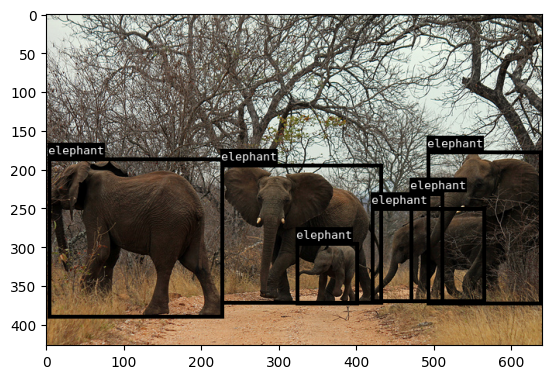

In [35]:
image_path = f"/data_ssd/mscoco2017/coco/images/{split}2017/{str(coco_data_index_list[index]).zfill(12)}.jpg"
assert os.path.exists(image_path), f"Image path {image_path} does not exist."
image_path = f"/data_ssd/mscoco2017/coco/images/{split}2017/{str(coco_data_index_list[index]).zfill(12)}.jpg"
from PIL import Image
visualize_bbox(f"{image_path}", [d["bbox"] for d in data], [d["category_name"] for d in data],bbox_is_relative=False)

In [36]:

target_list = cat_id2name.values()
question = make_question(target_list)
print(question)

Please carefully check the image and detect the following objects: [person, bicycle, car, motorcycle, airplane, bus, train, truck, boat, traffic light, fire hydrant, stop sign, parking meter, bench, bird, cat, dog, horse, sheep, cow, elephant, bear, zebra, giraffe, backpack, umbrella, handbag, tie, suitcase, frisbee, skis, snowboard, sports ball, kite, baseball bat, baseball glove, skateboard, surfboard, tennis racket, bottle, wine glass, cup, fork, knife, spoon, bowl, banana, apple, sandwich, orange, broccoli, carrot, hot dog, pizza, donut, cake, chair, couch, potted plant, bed, dining table, toilet, tv, laptop, mouse, remote, keyboard, cell phone, microwave, oven, toaster, sink, refrigerator, book, clock, vase, scissors, teddy bear, hair drier, toothbrush].


In [37]:
save_json_data = []
image_folder_root = "/data_ssd"
for coco_data_index in tqdm(coco_data_index_list):
    data = coco_detection_data[coco_data_index]
    image_path = f"mscoco2017/coco/images/{split}2017/{str(coco_data_index).zfill(12)}.jpg"
    assert os.path.exists(os.path.join(image_folder_root,image_path)), f"Image path {image_path} does not exist."
    
    
    object_name_list = []
    bbox_list = []
    for item in data:
        object_name_list.append(item["category_name"])
        bbox_list.append(item["bbox"])  # [x1, y1, x2, y2]の形式
    image_w_h_size = Image.open(os.path.join(image_folder_root,image_path)).size  # (width, height)
    object_name_with_loc_dict = make_object_name_with_loc_dict_per_image(object_name_list, bbox_list, image_w_h_size,sort_mode=sort_mode)
    answer = make_answer(object_name_with_loc_dict,target_list)
    
    conversation = make_conversation(
        id=f"mscoco2017-detection_{split}-{coco_data_index}",
        image_path=image_path,
        question=question,
        answer=answer,
    )
    
    save_json_data.append(conversation)


100%|██████████| 117266/117266 [02:56<00:00, 664.87it/s]


In [38]:
save_json_path = f"/data_ssd/mscoco-detection/original-split/original-{split}_bbox-{sort_mode}_for-kosmos2_mscoco2017-detection.json"

with open(save_json_path, "w") as f:
    json.dump(save_json_data, f, indent=4, ensure_ascii=False)

In [39]:
loaded_data = load_json(save_json_path)
print(f"Loaded {len(loaded_data)} conversations from {save_json_path}")
assert len(loaded_data) == len(save_json_data), "Loaded data length does not match the original data length."
for key,value in loaded_data[0].items():
    print(key, value)

Loaded 117266 conversations from /data_ssd/mscoco-detection/original-split/original-train_bbox-UDLR_for-kosmos2_mscoco2017-detection.json
id mscoco2017-detection_train-9
image mscoco2017/coco/images/train2017/000000000009.jpg
conversations [{'from': 'human', 'value': '<image><grounding> Please carefully check the image and detect the following objects: [person, bicycle, car, motorcycle, airplane, bus, train, truck, boat, traffic light, fire hydrant, stop sign, parking meter, bench, bird, cat, dog, horse, sheep, cow, elephant, bear, zebra, giraffe, backpack, umbrella, handbag, tie, suitcase, frisbee, skis, snowboard, sports ball, kite, baseball bat, baseball glove, skateboard, surfboard, tennis racket, bottle, wine glass, cup, fork, knife, spoon, bowl, banana, apple, sandwich, orange, broccoli, carrot, hot dog, pizza, donut, cake, chair, couch, potted plant, bed, dining table, toilet, tv, laptop, mouse, remote, keyboard, cell phone, microwave, oven, toaster, sink, refrigerator, book, cl

In [40]:
#valのdata_index=10がsort_mode=UDLRのときの例に最適
data_index = 10
data = save_json_data[data_index]
for key,value in data.items():
    print(key, value)


id mscoco2017-detection_train-72
image mscoco2017/coco/images/train2017/000000000072.jpg
conversations [{'from': 'human', 'value': '<image><grounding> Please carefully check the image and detect the following objects: [person, bicycle, car, motorcycle, airplane, bus, train, truck, boat, traffic light, fire hydrant, stop sign, parking meter, bench, bird, cat, dog, horse, sheep, cow, elephant, bear, zebra, giraffe, backpack, umbrella, handbag, tie, suitcase, frisbee, skis, snowboard, sports ball, kite, baseball bat, baseball glove, skateboard, surfboard, tennis racket, bottle, wine glass, cup, fork, knife, spoon, bowl, banana, apple, sandwich, orange, broccoli, carrot, hot dog, pizza, donut, cake, chair, couch, potted plant, bed, dining table, toilet, tv, laptop, mouse, remote, keyboard, cell phone, microwave, oven, toaster, sink, refrigerator, book, clock, vase, scissors, teddy bear, hair drier, toothbrush].'}, {'from': 'gpt', 'value': '<phrase> giraffe</phrase><object><patch_index_0099

In [41]:
value_question = data["conversations"][0]["value"]
print([value_question])
value_answer = data["conversations"][1]["value"]
print([value_answer])

['<image><grounding> Please carefully check the image and detect the following objects: [person, bicycle, car, motorcycle, airplane, bus, train, truck, boat, traffic light, fire hydrant, stop sign, parking meter, bench, bird, cat, dog, horse, sheep, cow, elephant, bear, zebra, giraffe, backpack, umbrella, handbag, tie, suitcase, frisbee, skis, snowboard, sports ball, kite, baseball bat, baseball glove, skateboard, surfboard, tennis racket, bottle, wine glass, cup, fork, knife, spoon, bowl, banana, apple, sandwich, orange, broccoli, carrot, hot dog, pizza, donut, cake, chair, couch, potted plant, bed, dining table, toilet, tv, laptop, mouse, remote, keyboard, cell phone, microwave, oven, toaster, sink, refrigerator, book, clock, vase, scissors, teddy bear, hair drier, toothbrush].']
['<phrase> giraffe</phrase><object><patch_index_0099><patch_index_1013></delimiter_of_multi_objects/><patch_index_0202><patch_index_1023></object>.']


In [42]:
processor = AutoProcessor.from_pretrained("/data_ssd/huggingface_model_weights/microsoft/kosmos-2-patch14-224")

{'person': 1, 'bicycle': 2, 'car': 3, 'motorcycle': 4, 'airplane': 5, 'bus': 6, 'train': 7, 'truck': 8, 'boat': 9, 'traffic light': 10, 'fire hydrant': 11, 'stop sign': 13, 'parking meter': 14, 'bench': 15, 'bird': 16, 'cat': 17, 'dog': 18, 'horse': 19, 'sheep': 20, 'cow': 21, 'elephant': 22, 'bear': 23, 'zebra': 24, 'giraffe': 25, 'backpack': 27, 'umbrella': 28, 'handbag': 31, 'tie': 32, 'suitcase': 33, 'frisbee': 34, 'skis': 35, 'snowboard': 36, 'sports ball': 37, 'kite': 38, 'baseball bat': 39, 'baseball glove': 40, 'skateboard': 41, 'surfboard': 42, 'tennis racket': 43, 'bottle': 44, 'wine glass': 46, 'cup': 47, 'fork': 48, 'knife': 49, 'spoon': 50, 'bowl': 51, 'banana': 52, 'apple': 53, 'sandwich': 54, 'orange': 55, 'broccoli': 56, 'carrot': 57, 'hot dog': 58, 'pizza': 59, 'donut': 60, 'cake': 61, 'chair': 62, 'couch': 63, 'potted plant': 64, 'bed': 65, 'dining table': 67, 'toilet': 70, 'tv': 72, 'laptop': 73, 'mouse': 74, 'remote': 75, 'keyboard': 76, 'cell phone': 77, 'microwave

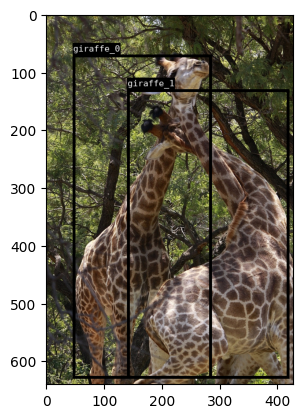

In [43]:
cat_id2name_dict = {v: k for k, v in cat_id2name.items()}
print(cat_id2name_dict)
_, answer_entities = processor.post_process_generation(value_answer)
object_list = [entity[0] for entity in answer_entities]
object_index_list = [cat_id2name_dict[object_name] for object_name in object_list]
print(object_index_list)
print(object_list)
print(answer_entities)

object_name_list = []
bbox_list = []
for entity in answer_entities:
    # for object_index in range(len(entity[-1])):
    #     object_name_list.append(entity[0]+str(object_index))  # entity[0]はオブジェクト名
    object_name_list.extend([entity[0]]*len(entity[-1]))  # entity[0]はオブジェクト名、entity[-1]はbboxのリスト
    bbox_list.extend(entity[-1])  # [x1, y1, x2, y2]の形式
image_w_h_size = Image.open(os.path.join(image_folder_root,data["image"])).size  # (width, height)
print(len(object_name_list), len(bbox_list))
visualize_bbox(f"{os.path.join(image_folder_root,data['image'])}", bbox_list, object_name_list,with_id=True)

[{'bbox': [136.63, 129.44, 425.71, 628.49], 'category_id': 25, 'category_name': 'giraffe', 'iscrowd': 0}, {'bbox': [50.45, 72.07, 283.96, 640.0], 'category_id': 25, 'category_name': 'giraffe', 'iscrowd': 0}]
[('giraffe', [136.63, 129.44, 425.71, 628.49]), ('giraffe', [50.45, 72.07, 283.96, 640.0])]
['giraffe', 'giraffe']
2 2


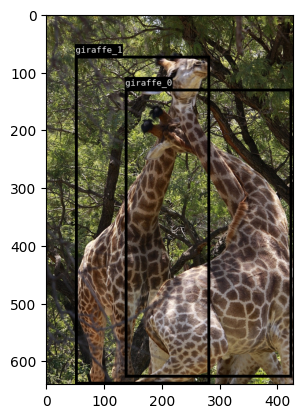

In [44]:
gt_data = coco_detection_data[int(data["id"].split("-")[-1])]
print(gt_data)

object_name_bbox_list = []
for item in gt_data:
    object_name_bbox_list.append((item["category_name"], item["bbox"]))  # (object_name, [x1, y1, x2, y2])

# for name,bbox in object_name_bbox_list:
#     print(name)
#     print(cat_id2name_dict[name])
sorted_object_name_bbox_list = sorted(object_name_bbox_list, key=lambda x: cat_id2name_dict[x[0]])
object_name_list = [item[0] for item in sorted_object_name_bbox_list]
bbox_list = [item[1] for item in sorted_object_name_bbox_list]
print(sorted_object_name_bbox_list)
print(object_name_list)
print(len(object_name_list), len(bbox_list))
image_w_h_size = Image.open(os.path.join(image_folder_root,data["image"])).size  # (width, height)
visualize_bbox(f"{os.path.join(image_folder_root,data['image'])}", bbox_list, object_name_list, bbox_is_relative=False,with_id=True)

# processorの複数領域を確認

In [ ]:

processor = AutoProcessor.from_pretrained("/data_ssd/huggingface_model_weights/microsoft/kosmos-2-patch14-224")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [101]:
tokenizer = processor.tokenizer
print(tokenizer.tokenize("“dry”"))

['▁“', 'dry', '”']


In [102]:
question = make_question(["person black", "car", "dog", "cat", "bicycle", "bus", "truck", "motorcycle", "train", "airplane"])
print(question)

Please carefully check the image and detect the following objects: [person black, car, dog, cat, bicycle, bus, truck, motorcycle, train, airplane].



In [103]:
vocab = processor.tokenizer.get_vocab()
vocab_list = list(sorted(vocab.items(), key=lambda x: x[1]))

In [104]:
print(vocab_list[-1030:-1023])

[('<phrase>', 64007), ('</phrase>', 64008), ('<object>', 64009), ('</object>', 64010), ('</delimiter_of_multi_objects/>', 64011), ('<grounding>', 64012), ('<patch_index_0000>', 64013)]


In [24]:
processor.post_process_generation("<phrase> person black</phrase><object><patch_index_0000><patch_index_0000></delimiter_of_multi_objects/><patch_index_0032><patch_index_0033></object>")

('person black',
 [('person black',
   (0, 12),
   [(0.0, 0.0, 0.03125, 0.03125), (0.0, 0.03125, 0.0625, 0.0625)])])

In [26]:
processor.post_process_generation("<phrase> person black</phrase><object><patch_index_0000><patch_index_0001></delimiter_of_multi_objects/><patch_index_0032><patch_index_0033></object>")

('person black',
 [('person black',
   (0, 12),
   [(0.0, 0.0, 0.0625, 0.03125), (0.0, 0.03125, 0.0625, 0.0625)])])